In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import re
import os
import time
import json
from datetime import datetime
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import joblib
from collections import Counter

In [39]:
# 设置随机种子，确保结果可重现
np.random.seed(42)

# 设置绘图样式
# plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

In [3]:
data_dir = "data/THUCNews"

files = {
    'train': os.path.join(data_dir, 'cnews.train.txt'),
    'val': os.path.join(data_dir, 'cnews.val.txt'),
    'test': os.path.join(data_dir, 'cnews.test.txt'),
    'vocab': os.path.join(data_dir, 'cnews.vocab.txt')
}

for name, path in files.items():
    if not os.path.exists(path):
        print(f"❌ 文件不存在: {path}")
        if name == 'vocab':
            print("💡 词汇表文件不是必需的，可以继续，但建议检查数据完整性")
        else:
            raise FileNotFoundError(f"必需的数据文件不存在: {path}")


files

{'train': 'data/THUCNews/cnews.train.txt',
 'val': 'data/THUCNews/cnews.val.txt',
 'test': 'data/THUCNews/cnews.test.txt',
 'vocab': 'data/THUCNews/cnews.vocab.txt'}

In [4]:
# 读取数据
def read_news_file(file_path):
    """读取新闻文件，返回(texts, labels)"""
    texts = []
    labels = []

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                # 分割类别和内容(使用制表符分割)
                parts = line.split('\t')
                if len(parts) >= 2:
                    label = parts[0].strip()
                    content = parts[1].strip()
                    # 只保留足够长度的文本
                    if len(content) > 10:
                        texts.append(content)
                        labels.append(label)
        
        print(f"✅ 从 {file_path} 读取了 {len(texts)} 条新闻")
        return texts, labels
    
    except Exception as e:
        print(f"❌ 读取文件 {file_path} 时出错: {e}")
        return [], []


In [ ]:
# 读取训练集
train_texts, train_labels = read_news_file(files['train'])

# 读取验证集
val_texts, val_labels = read_news_file(files['val'])

# 读取测试集
test_texts, test_labels = read_news_file(files['test'])

# 合并所有数据用于小样本训练
all_texts = train_texts + val_texts + test_texts
all_labels = train_labels + val_labels + test_labels

print(f"\ninfo:数据统计信息:")
print(f"总样本数: {len(all_texts)}")
print(f"训练集: {len(train_texts)}, 验证集: {len(val_texts)}, 测试集: {len(test_texts)}")

label_counter = Counter(all_labels)
print("\n类别分布:")
for category, count in sorted(label_counter.items()):
    print(f"  {category}: {count} 个样本")


✅ 从 data/THUCNews/cnews.train.txt 读取了 49999 条新闻
✅ 从 data/THUCNews/cnews.val.txt 读取了 5000 条新闻
✅ 从 data/THUCNews/cnews.test.txt 读取了 10000 条新闻

📊 数据统计信息:
总样本数: 64999
训练集: 49999, 验证集: 5000, 测试集: 10000

类别分布:
  体育: 6500 个样本
  娱乐: 6500 个样本
  家居: 6500 个样本
  房产: 6499 个样本
  教育: 6500 个样本
  时尚: 6500 个样本
  时政: 6500 个样本
  游戏: 6500 个样本
  科技: 6500 个样本
  财经: 6500 个样本


In [7]:
categories = sorted(set(all_labels))
print(f"所有类别 ({len(categories)}类):")
print(categories)

所有类别 (10类):
['体育', '娱乐', '家居', '房产', '教育', '时尚', '时政', '游戏', '科技', '财经']


In [9]:
# 加载词汇表
vocab = None
try:
    with open(files['vocab'], 'r', encoding='utf-8') as f:
        vocab = [line.strip() for line in f if line.strip()]
        print(f"\n📚 词汇表信息:")
        print(f"词汇表大小: {len(vocab)} 个词")
        print(f"前10个词汇: {vocab[:10]}")
        print(f"特殊标记: {vocab[0]} (通常表示填充)")
except Exception as e:
    print(f"⚠️  加载词汇表时出错: {e}")



📚 词汇表信息:
词汇表大小: 4997 个词
前10个词汇: ['<PAD>', '，', '的', '。', '一', '是', '在', '0', '有', '不']
特殊标记: <PAD> (通常表示填充)


In [11]:
# 加载中文停用词
stopwords_file = "data/stopwords_cn.txt"
stopwords = []

try:
    with open(stopwords_file, 'r', encoding='utf-8') as f:
        file_stopwords = [line.strip() for line in f if line.strip()]
        # 逐个添加
        stopwords.extend(file_stopwords)
        # 去重
        stopwords = set(stopwords)
        print(f"✅ 从文件加载了 {len(file_stopwords)} 个停用词")
except Exception as e:
    print(f"⚠️  加载停用词时出错: {e}")

stopwords

✅ 从文件加载了 849 个停用词


{'--',
 '<PAD>',
 '?',
 '“',
 '”',
 '》',
 '一',
 '一下',
 '一些',
 '一切',
 '一则',
 '一天',
 '一定',
 '一方面',
 '一旦',
 '一时',
 '一来',
 '一样',
 '一次',
 '一片',
 '一直',
 '一致',
 '一般',
 '一起',
 '一边',
 '一面',
 '万一',
 '上下',
 '上升',
 '上去',
 '上来',
 '上述',
 '上面',
 '下列',
 '下去',
 '下来',
 '下面',
 '不一',
 '不久',
 '不仅',
 '不会',
 '不但',
 '不光',
 '不单',
 '不变',
 '不只',
 '不可',
 '不同',
 '不够',
 '不如',
 '不得',
 '不怕',
 '不惟',
 '不成',
 '不拘',
 '不敢',
 '不断',
 '不是',
 '不比',
 '不然',
 '不特',
 '不独',
 '不管',
 '不能',
 '不要',
 '不论',
 '不足',
 '不过',
 '不问',
 '与',
 '与其',
 '与否',
 '与此同时',
 '专门',
 '且',
 '两者',
 '严格',
 '严重',
 '个',
 '个人',
 '个别',
 '中小',
 '中间',
 '丰富',
 '临',
 '为',
 '为主',
 '为了',
 '为什么',
 '为什麽',
 '为何',
 '为着',
 '主张',
 '主要',
 '举行',
 '乃',
 '乃至',
 '么',
 '之',
 '之一',
 '之前',
 '之后',
 '之後',
 '之所以',
 '之类',
 '乌乎',
 '乎',
 '乘',
 '也',
 '也好',
 '也是',
 '也罢',
 '了',
 '了解',
 '争取',
 '于',
 '于是',
 '于是乎',
 '云云',
 '互相',
 '产生',
 '人们',
 '人家',
 '什么',
 '什么样',
 '什麽',
 '今后',
 '今天',
 '今年',
 '今後',
 '仍然',
 '从',
 '从事',
 '从而',
 '他',
 '他人',
 '他们',
 '他的',
 '代替',
 '以',
 '以上',
 '以下',
 '以为',
 '以便',
 '

In [12]:
text = train_texts[0]

text = re.sub(r'https?://\S+|www\.\S+', '', text)   # 移除URL
text = re.sub(r'\S*@\S*\s?', '', text)  # 移除电子邮件地址
text = re.sub(r'[^\u4e00-\u9fa5]', '', text)    # 只保留汉字
text = re.sub(r'\s+', ' ', text).strip()    # 合并空白字符并去除首尾空格

# 2. 中文分词
if True:
    words = jieba.lcut(text)

# 4. 文本清洗
filtered_words = [
    word.strip() for word in words
    if word.strip() not in stopwords    # 不在停用词中
    and len(word.strip()) > 1       # 非单字词
    and not word.strip().isdigit()      # 不是纯数字
]

Processed_text = " ".join(filtered_words)


Processed_text[:50]

'马晓旭 意外 受伤 国奥 警惕 无奈 大雨 格外 青睐 殷家 记者 傅亚雨 沈阳 报道 来到 沈阳 '

In [13]:
# 中文预处理
def preprocess_cn_text(text, use_jieba=True):
    """
    Parameters:
    - use_jieba: 是否使用jieba分词
    """
    # 1. 移除特殊字符和噪声
    text = re.sub(r'https?://\S+|www\.\S+', '', text)   # 移除URL
    text = re.sub(r'\S*@\S*\s?', '', text)  # 移除电子邮件地址
    text = re.sub(r'[^\u4e00-\u9fa5]', '', text)    # 只保留汉字
    text = re.sub(r'\s+', ' ', text).strip()    # 合并空白字符并去除首尾空格

    if not text or len(text) < 5:
        return ""

    # 2. 中文分词
    if use_jieba:
        words = jieba.lcut(text)
    else:
        print("⚠️   简单按字符分割（不推荐，仅用于调试）")
        words = [char for char in text if char.strip()]

    # 3. 加载中文停用词
    # stopwords = stopwords
    
    # 4. 文本清洗
    filtered_words = [
        word.strip() for word in words
        if word.strip() not in stopwords    # 不在停用词中
        and len(word.strip()) > 1       # 非单字词
        and not word.strip().isdigit()      # 不是纯数字
    ]

    Processed_text = " ".join(filtered_words)

    return Processed_text


In [14]:
# 批次处理
def batch_preprocess_texts(texts, batch_size=1000):
    """
    批量预处理文本，显示进度
    """
    print("\n🔄 批量预处理中文文本...")
    print(f"总样本数: {len(texts)}")
    
    processed_texts = []
    start_time = time.time()
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_processed = [preprocess_cn_text(text) for text in batch]
        processed_texts.extend(batch_processed)
        
        # 显示进度
        progress = min(i + batch_size, len(texts))
        elapsed_time = time.time() - start_time
        avg_time_per_sample = elapsed_time / (i + batch_size)
        remaining_time = avg_time_per_sample * (len(texts) - progress)
        
        print(f"  进度: {progress}/{len(texts)} ({progress/len(texts)*100:.1f}%) "
              f"- 预计剩余时间: {remaining_time:.1f}秒")
    
    total_time = time.time() - start_time
    print(f"✅ 文本预处理完成！总耗时: {total_time:.2f}秒")

    return processed_texts

In [ ]:
# sample_size = 1000

# # 将标签转为数值
# label_encoder = LabelEncoder()
# y_encoder = label_encoder.fit_transform(categories)

# # 创建类别映射
# class_mapping = {i: category for i, category in enumerate(label_encoder.classes_)}
# print(f"类别映射: {class_mapping}")
# print(f"类别数量: {len(class_mapping)}")

# # 保证类别平衡的小样本选择
# # 按类别分组
# category_indices = {}
# for idx, label in enumerate(y_encoder):
#     if label not in category_indices:
#         category_indices[label] = []
#     category_indices[label].append(idx)

# # 为每个类别选择样本
# selected_indices = []
# samples_per_category = max(1, 1000 // len(class_mapping))

# for category, indices in category_indices.items():
#     # 随机选择该类别的样本
#     category_samples = min(len(indices), samples_per_category)
#     selected = np.random.choice(indices, category_samples, replace=False)
#     selected_indices.extend(selected)


# category_indices

类别映射: {0: '体育', 1: '娱乐', 2: '家居', 3: '房产', 4: '教育', 5: '时尚', 6: '时政', 7: '游戏', 8: '科技', 9: '财经'}
类别数量: 10


{0: [0],
 1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5],
 6: [6],
 7: [7],
 8: [8],
 9: [9]}

In [ ]:
# def prepare_thucnews_small_sample(texts, labels, sample_size=1000, 
#                                  feature_type='tfidf', max_features=2000, 
#                                  use_pca=False, n_components=150):
#     """
#     准备THUCNews小样本数据集（适配标准格式）
    
#     Parameters:
#     - sample_size: 小样本大小
#     - feature_type: 特征类型 ('tfidf', 'count', 'binary')
#     - max_features: 最大特征数
#     - use_pca: 是否使用PCA降维
#     - n_components: PCA降维后的维度
#     """

#     print(f"🔧 准备THUCNews小样本数据集 (样本数: {sample_size})...")
    
#     # 转换标签为数值
#     label_encoder = LabelEncoder()
#     y_encoded = label_encoder.fit_transform(labels)
    
#     # 创建类别映射
#     class_mapping = {i: category for i, category in enumerate(label_encoder.classes_)}
#     print(f"类别映射: {class_mapping}")
#     print(f"类别数量: {len(class_mapping)}")
    
#     # 保证类别平衡的小样本选择
#     print("\n🔄 选择类别平衡的小样本...")
    
#     # 按类别分组
#     category_indices = {}
#     for idx, label in enumerate(y_encoded):
#         if label not in category_indices:
#             category_indices[label] = []
#         category_indices[label].append(idx)
    
#     # 为每个类别选择样本
#     selected_indices = []
#     samples_per_category = max(1, sample_size // len(class_mapping))
    
#     for category, indices in category_indices.items():
#         # 随机选择该类别的样本
#         category_samples = min(len(indices), samples_per_category)
#         selected = np.random.choice(indices, category_samples, replace=False)
#         selected_indices.extend(selected)
    
    

In [15]:
train_labels_np = np.array(train_labels)
indices_tmp = np.where(train_labels_np == '房产')[0].tolist()

train_texts_category = train_texts[int(indices_tmp[0]): int(indices_tmp[-1]+1)]
len(indices_tmp),len(train_texts_category)

(4999, 4999)

In [20]:
def create_thucnews_sample(texts, labels, categories, sample_size=1000,
                           feature_type='tfidf', max_features=2000, 
                           use_pca=False, n_components=150):
    """
    准备THUCNews样本数据集（适配标准格式）
    
    Param:
    - sample_size: 小样本大小
    - feature_type: 特征类型 ('tfidf', 'count', 'binary')
    - max_features: 最大特征数
    - use_pca: 是否使用PCA降维
    - n_components: PCA降维后的维度
    """
    print(f"🔧 准备THUCNews小样本数据集 (样本数: {sample_size})...")

    # 检查样本数量
    if len(texts) < sample_size:
        print(f"⚠️  可用样本数({len(texts)})小于请求的样本数({sample_size})")
        sample_size = len(texts)
    
    # 1. 平衡采样
    label_array = np.array(labels)    # 转换成np,方便后续的处理
    samples_per_class = sample_size // len(categories)
    print(f"每类样本数: {samples_per_class}")

    selected_texts = []
    selected_labels = []

    for category in categories:
        # 获取该类别的所有索引
        indices = np.where(label_array == category)[0]
        
        if len(indices) == 0:
            print(f"⚠️  类别 '{category}' 没有样本")
            continue
        
        # 随机选取样本
        if len(indices) > samples_per_class:
            selected_indices = np.random.choice(indices, samples_per_class, replace=False)
        else:
            selected_indices = indices
        
        for idx in selected_indices:
            selected_texts.append(texts[idx])
            selected_labels.append(labels[idx])
    
    print(f"平衡采样后样本数: {len(selected_texts)}")

    # 2. 标签编码
    print("\n🏷️  编码标签...")
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(selected_labels)
    class_mapping = {i: class_name for i, class_name in enumerate(label_encoder.classes_)}
    print(f"类别映射: {class_mapping}")

    # 3. 文本预处理
    X_processed = batch_preprocess_texts(selected_texts)

    # 4. 特征提取
    print(f"\n📊 进行文本特征提取 ({feature_type.upper()})...")
    if feature_type == 'tfidf':
        # (?u)：Unicode模式
        # \b：单词边界
        # [\u4e00-\u9fa5]：匹配所有中文字符
        # +：一个或多个
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            lowercase=False,    # 中文不需要大小写
            min_df=3,       # 增加最小文档频率，过滤罕见词
            max_df=0.9,     # 降低最大文档频率
            token_pattern=r'(?u)\b[\u4e00-\u9fa5]+\b',
            use_idf=True
        )
    elif feature_type == 'count':
        vectorizer = CountVectorizer(
            max_features=max_features,
            lowercase=False,
            min_df=3
        )
    
    # 拟合
    X_features = vectorizer.fit_transform(X_processed)
    feature_names = vectorizer.get_feature_names_out()

    print(f"特征提取后形状: {X_features.shape}")
    print(f"词汇表大小: {len(feature_names)}")
    
    # 5. 稠密矩阵
    print("\n🔄 转换为稠密矩阵...")
    X_dense = X_features.toarray()
    print(f"稠密矩阵形状: {X_dense.shape}")

    # 6. 数据标准化
    print("\n📊 数据标准化...")
    scaler = StandardScaler(with_mean=False)  # 稀疏数据使用with_mean=False
    X_scaled = scaler.fit_transform(X_dense)
    print(f"标准化后形状: {X_scaled.shape}")

    # 7. PCA降维
    if use_pca:
        print(f"\n**ifno**: 应用PCA降维 (n_components={n_components})...")
        pca = PCA(
            n_components=n_components,
            random_state=42,
        )
        X_pca = pca.fit_transform(X_scaled)
        var = np.sum(pca.explained_variance_ratio_)
        print(f"PCA降维后形状: {X_pca.shape}")
        print(f"保留的方差比例: {var:.4f} ({var*100:.1f}%)")
        
        return X_pca, y_encoded, vectorizer, scaler, pca, feature_names, label_encoder, class_mapping
    else:
        return X_scaled, y_encoded, vectorizer, scaler, None, feature_names, label_encoder, class_mapping

In [19]:
sample_size = 1000  # 小样本大小
X_sample, y_sample, vectorizer, scaler, pca, feature_names, label_encoder, class_mapping = create_thucnews_sample(
    all_texts, all_labels, categories,
    sample_size=sample_size,
    feature_type='tfidf',
    max_features=2000,
    use_pca=True,
    n_components=150
)

🔧 准备THUCNews小样本数据集 (样本数: 1000)...
每类样本数: 100
平衡采样后样本数: 1000

🏷️  编码标签...
类别映射: {0: '体育', 1: '娱乐', 2: '家居', 3: '房产', 4: '教育', 5: '时尚', 6: '时政', 7: '游戏', 8: '科技', 9: '财经'}

🔄 批量预处理中文文本...
总样本数: 1000
  进度: 1000/1000 (100.0%) - 预计剩余时间: 0.0秒
✅ 文本预处理完成！总耗时: 13.61秒

📊 进行文本特征提取 (TFIDF)...
特征提取后形状: (1000, 2000)
词汇表大小: 2000

🔄 转换为稠密矩阵...
稠密矩阵形状: (1000, 2000)

📊 数据标准化...
标准化后形状: (1000, 2000)

 ifno: 应用PCA降维 (n_components=150)...
PCA降维后形状: (1000, 150)
保留的方差比例: 0.3814 (38.1%)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

In [ ]:
# 模型性能评估
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)       # 准确率不需要加权平均
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n{model_name} 模型评估结果:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [23]:
svm_model = SVC(
    kernel='linear',
    C=1.0,  # 正则化参数
    random_state=42,
    max_iter=1000,
    probability=True,
    verbose=True
)

start_time = time.time()
svm_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"✅ SVM训练完成！训练时间: {training_time:.2f}秒")

[LibSVM]*.*
optimization finished, #iter = 186
obj = -0.015847, rho = -0.349758
nSV = 44, nBSV = 0
Total nSV = 44
*.*
optimization finished, #iter = 182
obj = -0.017153, rho = -0.296187
nSV = 40, nBSV = 0
Total nSV = 40
.*
optimization finished, #iter = 220
obj = -0.015186, rho = -0.342167
nSV = 43, nBSV = 0
Total nSV = 43
*.*
optimization finished, #iter = 176
obj = -0.014713, rho = -0.223144
nSV = 45, nBSV = 0
Total nSV = 45
*.*
optimization finished, #iter = 154
obj = -0.016742, rho = -0.283516
nSV = 39, nBSV = 0
Total nSV = 39
*.*
optimization finished, #iter = 209
obj = -0.017228, rho = 0.308041
nSV = 47, nBSV = 0
*.*
optimization finished, #iter = 170
obj = -0.019505, rho = -0.704163
nSV = 34, nBSV = 0
Total nSV = 34
*
optimization finished, #iter = 124
obj = -0.021293, rho = -0.666801
nSV = 29, nBSV = 0
Total nSV = 29
*.*
optimization finished, #iter = 179
obj = -0.018394, rho = -0.635400
nSV = 39, nBSV = 0
Total nSV = 39
*.*
optimization finished, #iter = 144
obj = -0.021382, r

In [26]:
svm_metrics_small = evaluate_model(svm_model, X_test, y_test, model_name='SVM')


SVM 模型评估结果:
Accuracy:  0.8850
Precision: 0.8924
Recall:    0.8850
F1 Score:  0.8853


In [27]:
# MLP
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=64,  # 增大批量大小
    learning_rate='adaptive',
    max_iter=300,   # 增加最大迭代次数
    random_state=42,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15  # 增加早停耐心
)

start_time = time.time()
mlp_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"✅ MLP训练完成！训练时间: {training_time:.2f}秒")

Iteration 1, loss = 3.05039101
Validation score: 0.262500
Iteration 2, loss = 1.68586857
Validation score: 0.512500
Iteration 3, loss = 1.07652084
Validation score: 0.612500
Iteration 4, loss = 0.72204916
Validation score: 0.675000
Iteration 5, loss = 0.48391516
Validation score: 0.725000
Iteration 6, loss = 0.34936644
Validation score: 0.762500
Iteration 7, loss = 0.25596506
Validation score: 0.762500
Iteration 8, loss = 0.19708164
Validation score: 0.775000
Iteration 9, loss = 0.15230019
Validation score: 0.812500
Iteration 10, loss = 0.12295652
Validation score: 0.800000
Iteration 11, loss = 0.10049514
Validation score: 0.787500
Iteration 12, loss = 0.08272345
Validation score: 0.787500
Iteration 13, loss = 0.06937422
Validation score: 0.787500
Iteration 14, loss = 0.05900925
Validation score: 0.787500
Iteration 15, loss = 0.05063686
Validation score: 0.800000
Iteration 16, loss = 0.04400678
Validation score: 0.800000
Iteration 17, loss = 0.03874987
Validation score: 0.800000
Iterat

In [28]:
mlp_metrics_small = evaluate_model(mlp_model, X_test, y_test, model_name='MLP')


MLP 模型评估结果:
Accuracy:  0.8700
Precision: 0.8742
Recall:    0.8700
F1 Score:  0.8706


In [29]:
import joblib
import os
from datetime import datetime

# 创建保存目录
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

def save_model(model, scaler=None, model_name="model", dataset_name="thucn"):
    """
    保存模型和预处理器到本地
    
    Parameters:
    - model: 训练好的模型 (SVM或MLP)
    - scaler: 预处理器 (StandardScaler等)，可选
    - model_name: 模型名称 (如 "svm", "mlp")
    - dataset_name: 数据集名称
    """
    # 创建唯一的时间戳
    timestamp = datetime.now().strftime("%m%d_%H%M")
    
    # 构建文件名
    model_filename = f"{model_name}_{dataset_name}_{timestamp}.joblib"
    scaler_filename = f"{model_name}_{dataset_name}_scaler_{timestamp}.joblib"
    
    # 完整路径
    model_path = os.path.join(MODEL_DIR, model_filename)
    scaler_path = os.path.join(MODEL_DIR, scaler_filename)
    
    # 保存模型
    joblib.dump(model, model_path)
    print(f"✅ 模型已保存到: {model_path}")
    
    # 保存预处理器（如果存在）
    if scaler is not None:
        joblib.dump(scaler, scaler_path)
        print(f"✅ 预处理器已保存到: {scaler_path}")
    
    return model_path, scaler_path if scaler else None

In [30]:
svm_model_path, svm_scaler_path = save_model(
    model=svm_model,
    scaler=scaler, 
    model_name="svm",
    dataset_name="thucn_smp"
)

✅ 模型已保存到: models/svm_thucn_smp_0111_1718.joblib
✅ 预处理器已保存到: models/svm_thucn_smp_scaler_0111_1718.joblib


In [31]:
mlp_model_path, mlp_scaler_path = save_model(
    model=mlp_model,
    scaler=scaler, 
    model_name="mlp",
    dataset_name="thucn_smp"
)

✅ 模型已保存到: models/mlp_thucn_smp_0111_1718.joblib
✅ 预处理器已保存到: models/mlp_thucn_smp_scaler_0111_1718.joblib


In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

# 预测（两个模型）
svm_pred = svm_model.predict(X_test)
mlp_pred = mlp_model.predict(X_test)

In [35]:
def plot_confusion_matrix(y_true, y_pred, model_name, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,     # 显示数值
        fmt='d',    # 数值格式为整数
        cmap='Blues', 
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'{model_name} - CONFUSION MATRIX')
    plt.ylabel('REAL LABEL')
    plt.xlabel('PRED LABELS')
    plt.tight_layout()
    plt.show()


In [36]:
# 获取class_names
if hasattr(svm_model, 'classes_'):
    class_names = svm_model.classes_
else:
    # 获取唯一的类别标签
    class_names = np.unique(y_test)


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Gen

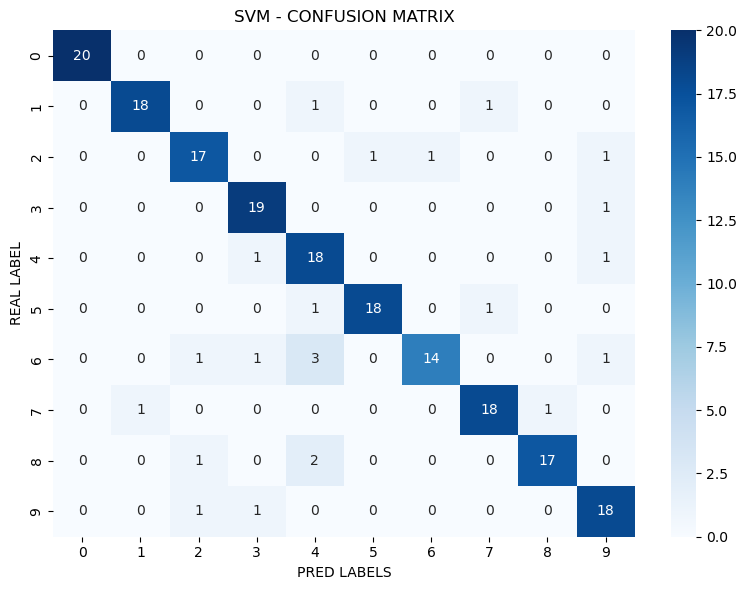

In [43]:
# 绘制混淆矩阵
plot_confusion_matrix(y_test, svm_pred, "SVM", class_names)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Gen

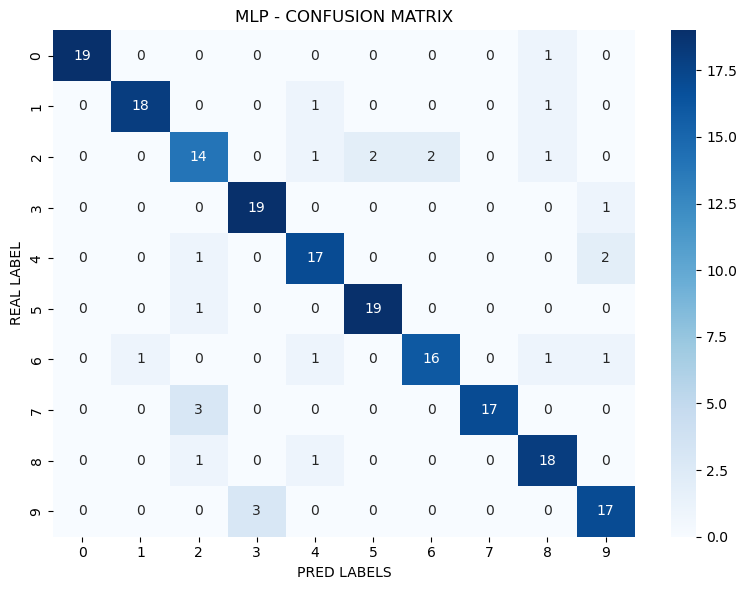

In [38]:
plot_confusion_matrix(y_test, mlp_pred, "MLP", class_names)

In [58]:
def plot_MLP_loss_cure(mlp_model, y_test, y_pred):
    plt.figure(figsize=(12, 5))

    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(mlp_model.loss_curve_, label='train loss')
    if hasattr(mlp_model, 'validation_scores_'):
        plt.plot(mlp_model.validation_scores_, label='vali socre')
    plt.title('MLP - loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

    # 准确率的曲线要在每轮迭代后手动计算
    # MLPClassifier不自动存储每轮的准确率历史
    plt.subplot(1, 2, 2)
    # 显示最终的准确率
    final_acc = accuracy_score(y_test, mlp_pred)
    plt.text(0.5, 0.5, f'final acc: {final_acc:.4f}', 
            ha='center', va='center', fontsize=16)
    plt.axis('off')
    plt.title('MLP - finak acc')
    plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Gen

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Gen

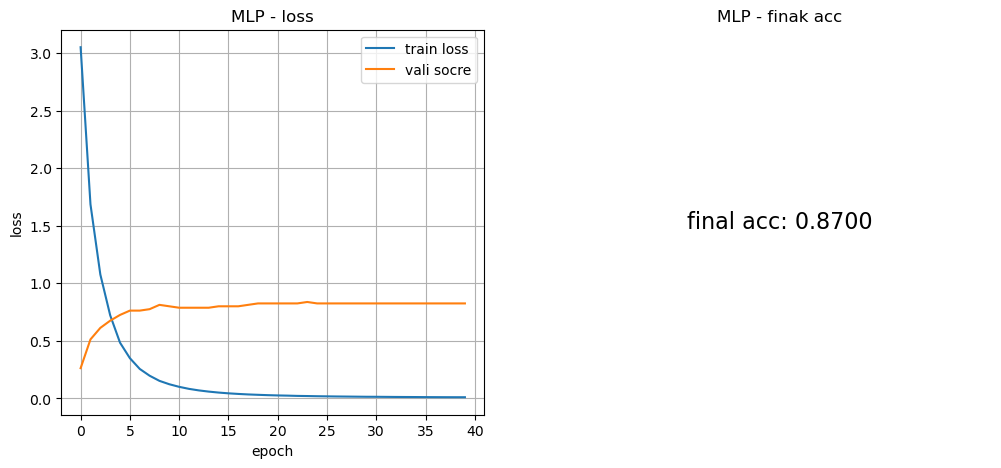

In [66]:
plot_MLP_loss_cure(mlp_model, y_test, mlp_pred)

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

def plot_SVM_diff_C(svm_model, X_train, y_train, X_test, y_test,
                        C_values=[0.001 ,0.01, 0.1, 1, 10, 100]):
    # 创建模型副本，避免污染原始模型
    base_model = clone(svm_model)

    # 测试不同C值的影响
    svm_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for C in C_values:
        # 创建当前C值的独立模型
        base_model.set_params(C=C)
        base_model.fit(X_train, y_train)
        y_pred = base_model.predict(X_test)
        
        svm_scores['accuracy'].append(accuracy_score(y_test, y_pred))
        svm_scores['precision'].append(
            precision_score(y_test, y_pred, average='weighted', zero_division=0)
        )
        svm_scores['recall'].append(
            recall_score(y_test, y_pred, average='weighted', zero_division=0)
        )
        svm_scores['f1'].append(
            f1_score(y_test, y_pred, average='weighted', zero_division=0)
        )

    # 绘制C值影响图
    plt.figure(figsize=(12, 6))
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(C_values, svm_scores[metric], 'bo-')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title(f'SVM - {metric.upper()} vs C')
        plt.xlabel('C val')
        plt.ylabel(metric.upper())
        plt.xscale('log')

        best_idx = np.argmax(svm_scores[metric])
        plt.annotate(f'Best C={C_values[best_idx]}', 
                    xy=(C_values[best_idx], svm_scores[metric][best_idx]),
                    xytext=(10, -15), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='red'))

    plt.tight_layout()
    plt.show()

[LibSVM]*.*
optimization finished, #iter = 148
obj = -0.014281, rho = -0.308556
nSV = 52, nBSV = 10
Total nSV = 52
*
optimization finished, #iter = 125
obj = -0.015283, rho = -0.252816
nSV = 47, nBSV = 13
Total nSV = 47
*.*
optimization finished, #iter = 177
obj = -0.013947, rho = -0.318016
nSV = 49, nBSV = 8
Total nSV = 49
*.*
optimization finished, #iter = 143
obj = -0.013863, rho = -0.260152
nSV = 49, nBSV = 13
Total nSV = 49
*.*
optimization finished, #iter = 185
obj = -0.014708, rho = -0.268476
nSV = 53, nBSV = 10
Total nSV = 53
*.*
optimization finished, #iter = 161
obj = -0.015598, rho = 0.292083
nSV = 52, nBSV = 11
*.*
optimization finished, #iter = 175
obj = -0.016864, rho = -0.601882
nSV = 55, nBSV = 15
Total nSV = 55
*.*
optimization finished, #iter = 140
obj = -0.017727, rho = -0.555135
nSV = 54, nBSV = 16
Total nSV = 54
*.*
optimization finished, #iter = 171
obj = -0.016259, rho = -0.561308
nSV = 55, nBSV = 16
Total nSV = 55
*.*
optimization finished, #iter = 151
obj = -0.

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei, Arial Unicode MS, Microsoft YaHei
findfont: Gen

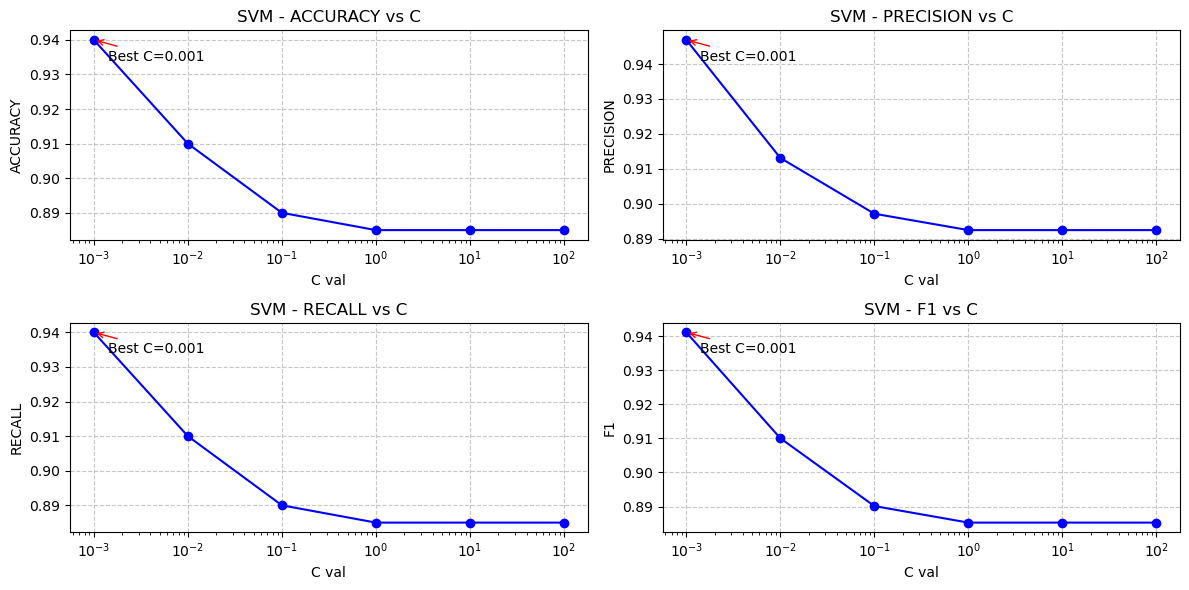

In [65]:
plot_SVM_diff_C(svm_model, X_train, y_train, X_test, y_test)